In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns

Границы отрезка

In [2]:
a = 0
b = np.pi / 2

Точное решение

In [3]:
def exact_solution(x):
    return np.cos(x)

Коэффициенты уравнения

In [4]:
def coeffs(x):
    p = np.ones_like(x)
    q = -np.sin(x)
    r = np.cos(x)
    f = 1 - np.cos(x)
    return p, q, r, f

Граничные условия

In [5]:
alpha = np.array([1, 0])
beta = np.array([1, 0])
gamma = np.array([exact_solution(a), exact_solution(b)])

Построение СЛАУ методом прогонки

In [ ]:
def thomas_algorithm(A, B):
    n = len(B)
    c_prime = np.zeros(n - 1)
    d_prime = np.zeros(n)

    c_prime[0] = A[0, 1] / A[0, 0]
    d_prime[0] = B[0] / A[0, 0]

    for i in range(1, n-1):
        denom = A[i, i] - A[i, i - 1] * c_prime[i - 1]
        c_prime[i] = A[i, i + 1] / denom
        d_prime[i] = (B[i] - A[i, i - 1] * d_prime[i - 1]) / denom

    d_prime[-1] = (B[-1] - A[-1, -2] * d_prime[-2]) / (A[-1, -1] - A[-1, -2] * c_prime[-2])

    y = np.zeros(n)
    y[-1] = d_prime[-1]
    for i in range(n - 2, -1, -1):
        y[i] = d_prime[i] - c_prime[i] * y[i + 1]
    return y

Построение СЛАУ и решение с контролем точности

In [ ]:
def build_system(a, b, alpha, beta, gamma, N, coeffs_data=None):
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)

    if coeffs_data is not None:
        old_x = coeffs_data["x"]
        p = np.interp(x, old_x, coeffs_data["p"])
        q = np.interp(x, old_x, coeffs_data["q"])
        r = np.interp(x, old_x, coeffs_data["r"])
        f = np.interp(x, old_x, coeffs_data["f"])
    else:
        p, q, r, f = coeffs(x)

    A = np.zeros((N + 1, N + 1))
    B = np.zeros(N + 1)

    A[0, 0] = alpha[0]
    B[0] = gamma[0]

    A[N, N] = beta[0]
    B[N] = gamma[1]

    for i in range(1, N):
        A[i, i - 1] = (1 / h**2) - q[i] / (2 * h)
        A[i, i] = -2 / h**2 + r[i]
        A[i, i + 1] = (1 / h**2) + q[i] / (2 * h)
        B[i] = f[i]

    coeffs_data = {"x": x, "p": p, "q": q, "r": r, "f": f}
    return x, A, B, coeffs_data

In [ ]:
def solve_with_accuracy(a, b, alpha, beta, gamma, tol=1e-6, max_N=100000):
    N = 10
    prev_y = None
    prev_x = None
    coeffs_data = None

    while N <= max_N:
        x, A, B, coeffs_data = build_system(a, b, alpha, beta, gamma, N, coeffs_data)
        y_num = thomas_algorithm(A, B)

        if prev_y is not None:
            error = np.max(np.abs(y_num[::2] - prev_y))
            if error < tol:
                return x, y_num, N

        prev_y = y_num
        prev_x = x
        N *= 2

    raise ValueError(f"Не достигнута точность при N={N}")

График численного и точного решения

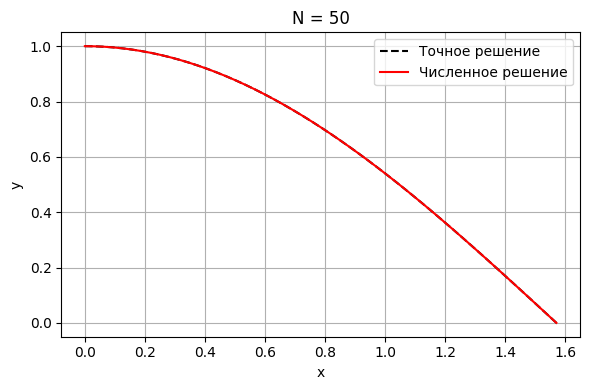

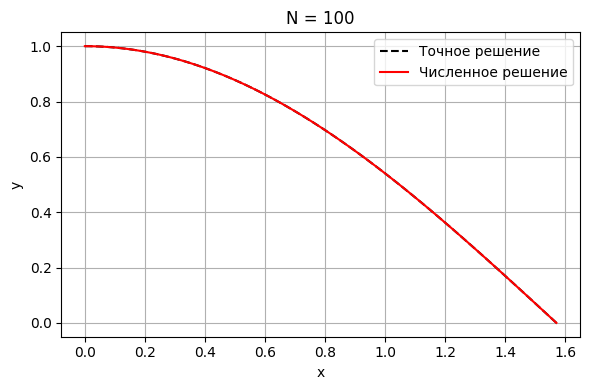

In [9]:
Ns = [50, 100]
for N in Ns:
    x, A, B, coeffs_data = build_system(a, b, alpha, beta, gamma, N)
    y_num = thomas_algorithm(A, B)
    y_ex = exact_solution(x)

    plt.figure(figsize=(6, 4))
    plt.plot(x, y_ex, 'k--', label='Точное решение')
    plt.plot(x, y_num, 'r-', label='Численное решение')
    plt.title(f'N = {N}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

Графики числа итераций и ошибки от точности

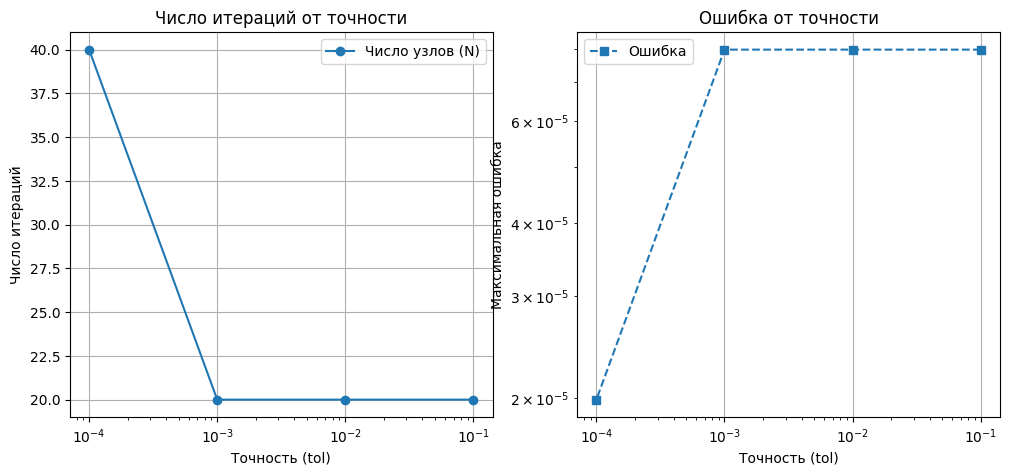

In [10]:
tolerances = [1e-1, 1e-2, 1e-3, 1e-4]
iterations = []
errors_tol = []

for tol in tolerances:
    x, y_num, N = solve_with_accuracy(a, b, alpha, beta, gamma, tol=tol)
    y_ex = exact_solution(x)
    iterations.append(N)
    errors_tol.append(np.max(np.abs(y_ex - y_num)))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tolerances, iterations, 'o-', label="Число узлов (N)")
plt.xscale('log')
plt.xlabel('Точность (tol)')
plt.ylabel('Число итераций')
plt.title('Число итераций от точности')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tolerances, errors_tol, 's--', label="Ошибка")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Точность (tol)')
plt.ylabel('Максимальная ошибка')
plt.title('Ошибка от точности')
plt.grid(True)
plt.legend()

График ошибки от шага

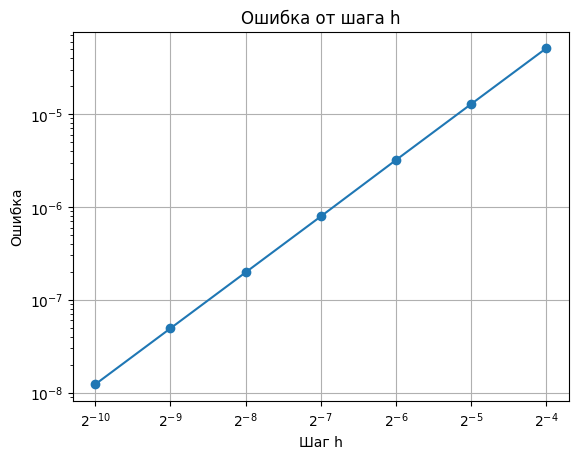

In [11]:
step_sizes = [2 ** (-n) for n in range(4, 11)]
errors = []
for h in step_sizes:
    N = int((b - a) / h)
    x, A, B, coeffs_data = build_system(a, b, alpha, beta, gamma, N)
    y_num = thomas_algorithm(A, B)
    y_ex = exact_solution(x)
    errors.append(np.max(np.abs(y_ex - y_num)))

plt.figure()
plt.plot(step_sizes, errors, 'o-')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('Шаг h')
plt.ylabel('Ошибка')
plt.title('Ошибка от шага h')
plt.grid(True)

Исследование сходимости метода

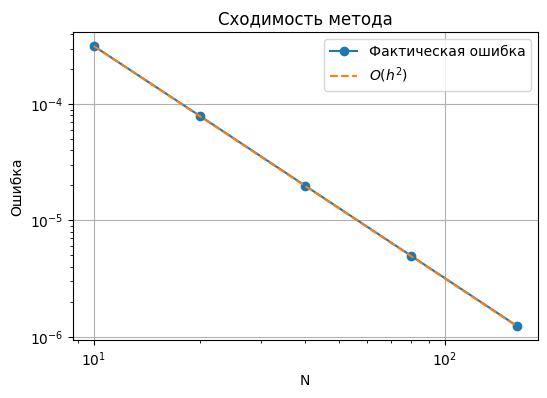

In [12]:
Ns = [10, 20, 40, 80, 160]
errors = []

for N in Ns:
    x, A, B, coeffs_data = build_system(a, b, alpha, beta, gamma, N)
    y_num = thomas_algorithm(A, B)
    y_ex = exact_solution(x)
    errors.append(np.max(np.abs(y_ex - y_num)))

plt.figure(figsize=(6, 4))
plt.loglog(Ns, errors, 'o-', label='Фактическая ошибка')
plt.loglog(Ns, [errors[0] * (Ns[0]/n)**2 for n in Ns], '--', label=r'$O(h^2)$')
plt.xlabel('N')
plt.ylabel('Ошибка')
plt.title('Сходимость метода')
plt.grid(True)
plt.legend()

Оценка порядка сходимости

In [13]:
por, _, _, _, _ = linregress(np.log(Ns), np.log(errors))
print(f"Оценка порядка метода: {abs(por):.2f}")

Оценка порядка метода: 2.00


Возмущение коэффициентов уравнения

In [14]:
def coeffs_perturbed(x, perturb_percent):
    rng = np.random.default_rng()
    noise = perturb_percent / 100
    p = 1 + noise * rng.uniform(-1, 1, size=x.shape)
    q = -np.sin(x) * (1 + noise * rng.uniform(-1, 1, size=x.shape))
    r = np.cos(x) * (1 + noise * rng.uniform(-1, 1, size=x.shape))
    f = 1 - np.cos(x)
    return p, q, r, f

Сбор результатов по возмущениям

In [15]:
perturb_levels = [1, 2, 3, 4, 5]
runs_per_level = 20
N = 100
errors_by_perturb = []

for level in perturb_levels:
    level_errors = []
    for _ in range(runs_per_level):
        h = (b - a) / N
        x = np.linspace(a, b, N + 1)
        p, q, r, f = coeffs_perturbed(x, level)

        A = np.zeros((N + 1, N + 1))
        B = np.zeros(N + 1)

        A[0, 0] = alpha[0]
        B[0] = gamma[0]
        A[N, N] = beta[0]
        B[N] = gamma[1]

        for i in range(1, N):
            A[i, i - 1] = (1 / h**2) - q[i] / (2 * h)
            A[i, i]     = -2 / h**2 + r[i]
            A[i, i + 1] = (1 / h**2) + q[i] / (2 * h)
            B[i] = f[i]

        y_pert = thomas_algorithm(A, B)
        y_ex = exact_solution(x)
        err = np.max(np.abs(y_pert - y_ex)) / np.max(np.abs(y_ex)) * 100
        level_errors.append(err)
    errors_by_perturb.append(level_errors)

Построение боксплота

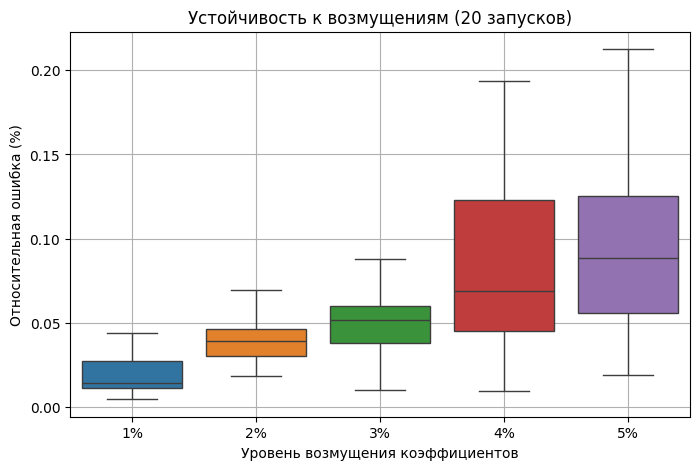

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=errors_by_perturb, showfliers=False)
plt.xticks(ticks=np.arange(5), labels=[f"{p}%" for p in perturb_levels])
plt.xlabel("Уровень возмущения коэффициентов")
plt.ylabel("Относительная ошибка (%)")
plt.title("Устойчивость к возмущениям (20 запусков)")
plt.grid()